## **Import necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, SpatialDropout1D
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical # np_utils has been replaced by to_categorical
import re  # For regex in text cleaning
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from keras.callbacks import EarlyStopping

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...



## **Load the Dataset**

In [2]:
dataset_path = '/content/Dataset-SA.csv'
dataset = pd.read_csv(dataset_path)
dataset.head()

,product_name,product_price,Rate,Review,Summary,Sentiment
0,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,super!,great cooler excellent air flow and for this p...,positive
1,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,awesome,best budget 2 fit cooler nice cooling,positive
2,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,the quality is good but the power of air is de...,positive
3,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,1,useless product,very bad product its a only a fan,negative
4,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,ok ok product,neutral


## **Explore Data**

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205052 entries, 0 to 205051
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   product_name   205052 non-null  object
 1   product_price  205052 non-null  object
 2   Rate           205052 non-null  object
 3   Review         180388 non-null  object
 4   Summary        205041 non-null  object
 5   Sentiment      205052 non-null  object
dtypes: object(6)
memory usage: 9.4+ MB


In [4]:
dataset.describe()

,product_name,product_price,Rate,Review,Summary,Sentiment
count,205052,205052,205052,180388,205041,205052
unique,958,525,8,1324,92923,3
top,cello Pack of 18 Opalware Cello Dazzle Lush Fi...,1299,5,wonderful,good,positive
freq,6005,9150,118765,9016,17430,166581


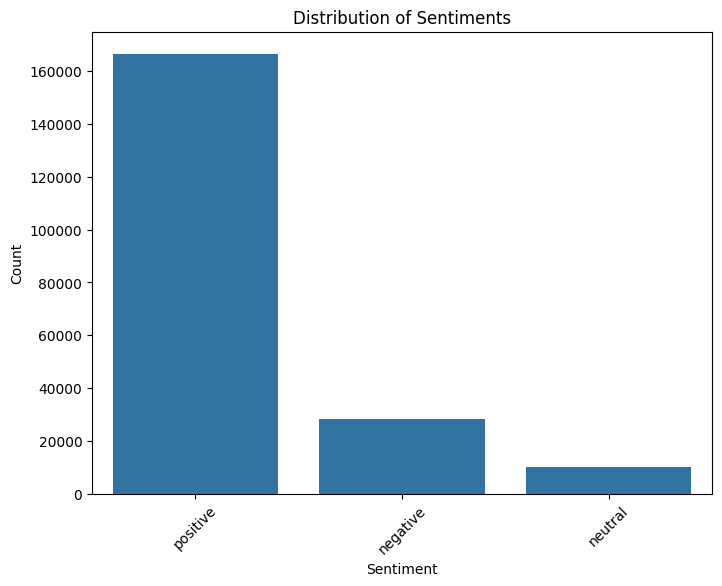

In [5]:
# Visualize the distribution of sentiments
plt.figure(figsize=(8, 6))
sns.countplot(data=dataset, x='Sentiment')
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## **Process Data**

In [6]:
# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [7]:
# Clean and preprocess text (function to clean text data)
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    # Remove stopwords and apply lemmatization
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

In [8]:
# Apply cleaning function to both Review and Summary
dataset['cleaned_review'] = dataset['Review'].apply(clean_text)
dataset['cleaned_summary'] = dataset['Summary'].apply(clean_text)

In [9]:
# Combine cleaned 'Review' and 'Summary' for better context
dataset['combined_text'] = dataset['cleaned_review'] + ' ' + dataset['cleaned_summary']

In [10]:
# Filter out neutral sentiments
dataset = dataset[dataset['Sentiment'] != 'neutral']
dataset = dataset[['combined_text', 'Sentiment']]
dataset.head()

,combined_text,Sentiment
0,super great cooler excellent air flow price am...,positive
1,awesome best budget fit cooler nice cooling,positive
2,fair quality good power air decent,positive
3,useless product bad product fan,negative
5,awesome cooler really fantastic provides good ...,positive


In [11]:
# Target labels (Sentiment) - Map only 'positive' and 'negative' to numerical values
sentiment_map = {'positive': 1, 'negative': 0}  # Binary mapping
dataset['Sentiment'] = dataset['Sentiment'].map(sentiment_map)

In [12]:
# Check for missing values and drop them (if any)
dataset.dropna(subset=['combined_text', 'Sentiment'], inplace=True)

In [13]:
# Check the distribution of review lengths
combined_text_lengths = dataset['combined_text'].apply(lambda x: len(x.split()))
print(f'Average combined_text length: {combined_text_lengths.mean()}')
print(f'Maximum combined_text length: {combined_text_lengths.max()}')
print(f'Shortest combined_text length: {combined_text_lengths.min()}')

Average combined_text length: 6.408324906448748
Maximum combined_text length: 67
Shortest combined_text length: 1


In [14]:
# Check the size of the vocabulary
all_words = ' '.join(dataset['combined_text']).split()
unique_words = set(all_words)
print(f'Number of unique words: {len(unique_words)}')

Number of unique words: 39477


In [15]:
# okenization and Padding
max_features  = 10000  # The number of unique words to use (top 10000 words)
maxlen = 30
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True, oov_token='UNK')
tokenizer.fit_on_texts(dataset['combined_text'].values)
X = tokenizer.texts_to_sequences(dataset['combined_text'].values)
# Padding the sequences to ensure they all have the same length
X = pad_sequences(X, maxlen=maxlen)

# Label encoding and one-hot encoding of target labels
y = pd.get_dummies(dataset['Sentiment']).values

In [16]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **RNN Model**

In [19]:
# Calculate class weights for handling imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))

# Convert class weights to a dictionary
class_weights = dict(enumerate(class_weights))

# Build the RNN model
embedding_dimension = 128  # Embedding size for each word vector
rnn_units = 128  # Number of RNN units in each layer

model = Sequential()
model.add(Embedding(max_features, embedding_dimension, input_length=X.shape[1]))  # Embedding layer
model.add(SimpleRNN(rnn_units, return_sequences=True))  # First RNN layer
model.add(SimpleRNN(rnn_units))  # Second RNN layer
model.add(Dense(2, activation='softmax'))  # Output layer with softmax for binary classification

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Train the model using class weights
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weights, callbacks=[early_stopping])

# Assuming y_test are the true labels and y_pred are the predicted labels from your model
y_pred = model.predict(X_test)  # Get predictions from the model
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with the highest probability
y_true_classes = np.argmax(y_test, axis=1)  # True classes

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


4871/4871 ━━━━━━━━━━━━━━━━━━━━ 50s 9ms/step - accuracy: 0.8959 - loss: 0.2617 - val_accuracy: 0.9479 - val_loss: 0.1630
Epoch 2/10
4871/4871 ━━━━━━━━━━━━━━━━━━━━ 77s 9ms/step - accuracy: 0.9295 - loss: 0.2027 - val_accuracy: 0.9540 - val_loss: 0.1363
Epoch 3/10
4871/4871 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - accuracy: 0.9393 - loss: 0.1774 - val_accuracy: 0.9269 - val_loss: 0.1878
Epoch 4/10
4871/4871 ━━━━━━━━━━━━━━━━━━━━ 83s 9ms/step - accuracy: 0.9485 - loss: 0.1551 - val_accuracy: 0.9138 - val_loss: 0.2354
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


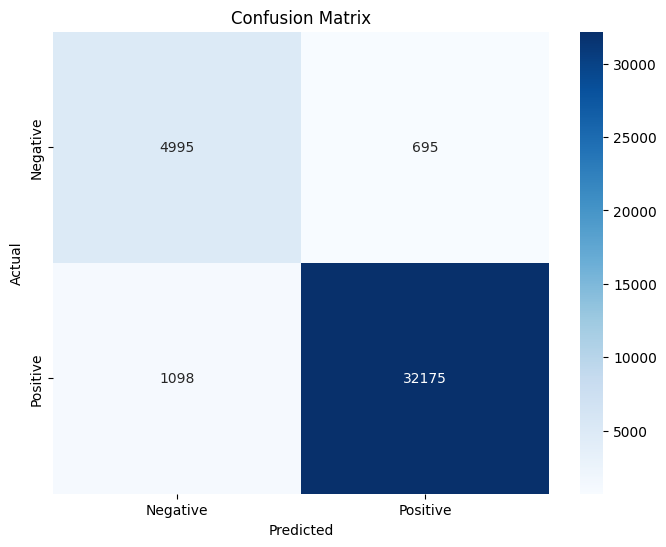

              precision    recall  f1-score   support

    Negative       0.82      0.88      0.85      5690
    Positive       0.98      0.97      0.97     33273

    accuracy                           0.95     38963
   macro avg       0.90      0.92      0.91     38963
weighted avg       0.96      0.95      0.95     38963



In [20]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Step 2: Visualize confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=['Negative', 'Positive'])
print(report)